## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

In [7]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

file = "data/data_000637.txt"
df = pd.read_csv(file)

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [9]:
#1

N = 12000
print("Data from 0 to {}: \n{}".format(N, df[0:N]))

Data from 0 to 12000: 
       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
11995     1     0          139  3869200286        3251         0
11996     1     0           62  3869200286        3246         4
11997     1     0           58  3869200286        3246        11
11998     1     0           61  3869200286        3251        17
11999     1     0           59  3869200286        3248        16

[12000 rows x 6 columns]


In [10]:
#2
x = np.max(df['BX_COUNTER'])
print("The value of BX in an orbit:", x)

The value of BX in an orbit: 3563


In [24]:
#3 & 4
df['time_ns'] = (df['ORBIT_CNT']*x+df['BX_COUNTER'])*25
data_ac = df['time_ns'].max() - df['time_ns'].min()
print('out how much the data taking lasted:',data_ac,'ns')

out how much the data taking lasted: 980141175 ns


In [15]:
#5
rhead = np.random.randint(0,2, (df.shape[0], 1))
df['HEAD'] = rhead

In [17]:
#6
d1 = pd.DataFrame(df.loc[df['HEAD'] == 1])
print(d1.head())

    HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0      1     0          123  3869200167        2374        26
6      1     0           61  3869200167        2772        14
8      1     0           62  3869200167        2774        21
12     1     1            6  3869200167        2792        18
14     1     0           56  3869200167        2789         3


TDC channel with FPGA=0:


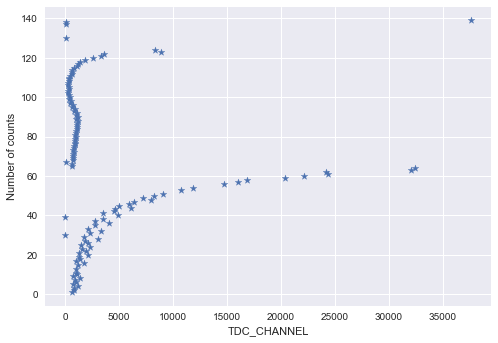

TDC channel with FPGA=1:


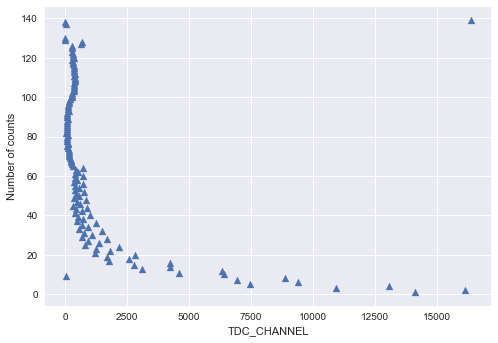

In [40]:
#7 
fpga0 = pd.DataFrame(d1.loc[df['FPGA']==0])
fpga1 = pd.DataFrame(d1.loc[df['FPGA']==1])

#fpga0

count0 = fpga0['TDC_CHANNEL'].value_counts()
v0 = count0.values
k0 = count0.keys()

#fpga1
count1 = fpga1['TDC_CHANNEL'].value_counts()
v1 = count1.values
k1 = count1.keys()

print("TDC channel with FPGA=0:")
plt.scatter(v0,k0, marker = '*')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Number of counts')
plt.show()

print("TDC channel with FPGA=1:")
plt.scatter(v1,k1, marker = '^')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Number of counts')
plt.show()


In [30]:
#8
tdc3 = (df['TDC_CHANNEL'].value_counts()).groupby((df['TDC_CHANNEL'].value_counts())).nlargest(3)
print("The most 3 TDC noisy channels: \n", tdc3[:3])

The most 3 TDC noisy channels: 
 139    108059
64      66020
63      64642
Name: TDC_CHANNEL, dtype: int64


In [42]:
#9
print("Number of unique orbits: ", df['ORBIT_CNT'].nunique())

tdc139 = df.loc[df['TDC_CHANNEL'] == 139, 'ORBIT_CNT']
print("Number of unique orbits with TDC_CHANNEL = 139: ",tdc139.nunique())

Number of unique orbits:  11001
Number of unique orbits with TDC_CHANNEL = 139:  10976
